In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/train.csv', index_col=0)

In [3]:
print(df.columns)
print(df.shape)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(891, 11)


In [4]:
df.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
204,0,3,"Youseff, Mr. Gerious",male,45.5,0,0,2628,7.225,NaN,C
820,0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.900,NaN,S
461,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.550,E12,S
211,0,3,"Ali, Mr. Ahmed",male,24.0,0,0,SOTON/O.Q. 3101311,7.050,NaN,S
806,0,3,"Johansson, Mr. Karl Johan",male,31.0,0,0,347063,7.775,NaN,S


In [5]:
# The age column has nas, but they don't seem special at first sight.
# I'll fill them with the median

df[df['Age'].isnull()].sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S
496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S


In [20]:
# Substitute missing ages with the median (28)

def replace_with_median(dataframe, column):
    age = df['Age'][:]
    median_age = age.median()
    age[age.isnull()] = median_age
    
    return age
    
df2 = df[:]
df2['Age'] = replace_with_median(df2, 'Age')

In [7]:
# Encode cabin as 'data present' vs 'absent'
df2['Cabin'] = ~df2['Cabin'].isnull()

In [8]:
discrete_columns = ['Pclass','Sex', 'Cabin', 'Embarked']

# Workaround to get pandas to behave as I want
# Otherwise it keeps multilevel integer variables in a single column
def one_hot(dataframe, discrete_columns):
    
    dummies = []
    for column in discrete_columns:
        these_dummies = pd.get_dummies(dataframe[column], prefix=column, drop_first=True)
        dummies.append(these_dummies)
        
    return pd.concat(dummies, axis=1)
    
discrete = one_hot(df2, discrete_columns)

In [19]:
continuous_columns = ['Age', 'Fare']

def normalize_continuous(dataframe, continuous_columns):
    continuous = df2[continuous_columns]
    return (continuous - continuous.mean()) / (continuous.max() - continuous.min())

continuous_normalized = normalize_continuous(df2, continuous_columns)

In [10]:
features = pd.concat([discrete, continuous_normalized], axis=1)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, df2['Survived'], test_size=0.3)

print(X_train.shape)
print(X_test.shape)

(623, 8)
(268, 8)


In [12]:
from sklearn.ensemble.forest import RandomForestClassifier

forest = RandomForestClassifier()
model = forest.fit(X_train, Y_train)
predicted_probs = model.predict_proba(X_test)[:,1]
predicted_class = model.predict(X_test)

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

roc = roc_curve(Y_test, predicted_probs)
print(roc_auc_score(Y_test, predicted_probs))
print(f1_score(Y_test, predicted_class))

0.850931856211
0.772277227723


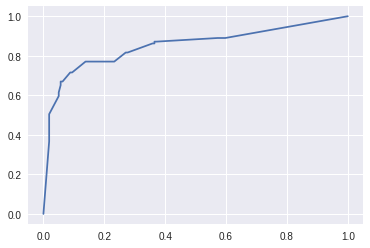

In [14]:
ax = plt.plot(roc[0],roc[1])

Decent enough! Let's play around a bit more

In [15]:
# Let's use cross validation to waste less data and compare to an svm:
from sklearn.model_selection import cross_val_predict

rf_predictions = cross_val_predict(forest, features, df2['Survived'], cv=10)


from sklearn import svm

SVM = svm.SVC(kernel='linear', C=1)

svm_predictions = cross_val_predict(SVM, features, df2['Survived'], cv=10)

In [16]:
print(f1_score(df2['Survived'], rf_predictions))
print(f1_score(df2['Survived'], svm_predictions))

0.752655538695
0.710365853659
